# Cross Validation
Cross validation is an important topic in the `Machine Learning` to ensure that our model is robust enough. Traditional training strategy is using 3 parts of the dataset for training, testing a validation.

* training set - is used to train the model and optimaze the hyperparameters of the model
* testing set - is used to evalutate that the model generalize enough to correctly work on data it was not trained on. However through the person doing the optimazation some knoweldge about the test set eventually leaks into the model.
* validation set - for that reason we use validation set which is used as the final check that model is able to generalize with previously unknown data.

Creating these sets limit the number of data which are used for the training and that can decrease the model's ability to learn. Cross validation allows to make a robust model by spliting the training data into `k` subsets. Each subsets uses part of it's data for training and part to test. Next subset uses different split of train and test data as you can see on the picture below. This is more intensive on the resources, but allow you to use mode data for training.

![](Cross_Validation.jpg "Cross validation folds")

You can also be sure that your model is able to generalize, in case each of the fold has similar performace. If one (or more) fold is achieving really for score while others perform badly, you need to think more about the way how you split the data. You will see examples of this below. 

`Scikit Learn` is favorite python library to perform many machine learning operations and it brings many methods which helps to split the data into training, testing and validation set. The most popular which we will review in this tutorial are: 

* train_test_split - creates single split into train and test set.
* Kfold - creates k-fold splits allowing cross validation
* StratifiedKFold - creates k-fold splits considering the distribution of the target variable
* cross_val_score - evaluta model's score through cross validation

You should be aware that cross-validation is however not suitable for all the occasions and you should think wisely how you split the data.

More about cross validaiton:
* https://scikit-learn.org/stable/modules/cross_validation.html
* https://en.wikipedia.org/wiki/Cross-validation_(statistics)

Let's have a look at some real usecases. We will first split simple **range of 25 numbers** and then we will look at popular **Iris dataset** which uses petal and sepal measurements to predict which kind of Iris flower it is. 

In [100]:
# Import scikit-learn libraries
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# import libraries for charting and manipulations with datasets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

In [6]:
# create the range 1 to 25
rn = range(1,26)

Let's start with the Kfold method which splits the train set into k-folds so that each sample is used once for testing and k-1 times for training. 

In [7]:
# to demonstrate how the data are split, we will create 3 and 5 folds. 
# KFold function has to be applied on the data and it returns an location (index) of the train and test samples.
kf5 = KFold(n_splits=5, shuffle=False)
kf3 = KFold(n_splits=3, shuffle=False)

In [8]:
# the Kfold function retunrs the indices of the data. Our range goes from 1-25 so the index is 0-24
for train_index, test_index in kf3.split(rn):
    print(train_index, test_index)

[ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] [0 1 2 3 4 5 6 7 8]
[ 0  1  2  3  4  5  6  7  8 17 18 19 20 21 22 23 24] [ 9 10 11 12 13 14 15 16]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [17 18 19 20 21 22 23 24]


In [9]:
# to get the values from our data, we use np.take() to access a value at particular index
for train_index, test_index in kf3.split(rn):
    print(np.take(rn,train_index), np.take(rn,test_index))

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25] [1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 18 19 20 21 22 23 24 25] [10 11 12 13 14 15 16 17]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] [18 19 20 21 22 23 24 25]


## Chart the cross validation split

In [10]:
# Let's split our test range into 5 and3  folds and display the splits on the chart.
# In order to clearly show which data belongs to each set, we will shift the values by -.1 and +.1
# the first fold will contain values 0.9 in train and 1.1 in the test set, second 1.9 and 2.1, etc.
# we will also give each sets the different color
# because we will repeat this exercise for the shuffled version, let's create a function 

def kfoldize(kf, rn, shift=.1):
    train = pd.DataFrame()
    test = pd.DataFrame()
    i = 1
    for train_index, test_index in kf.split(rn):
        train_df = pd.DataFrame(np.take(rn, train_index), columns=["x"])
        train_df["val"] = i - shift
        train = train.append(train_df)

        test_df = pd.DataFrame(np.take(rn, test_index), columns=["x"])
        test_df["val"] = i + shift
        test = test.append(test_df)
        i += 1
    return train, test

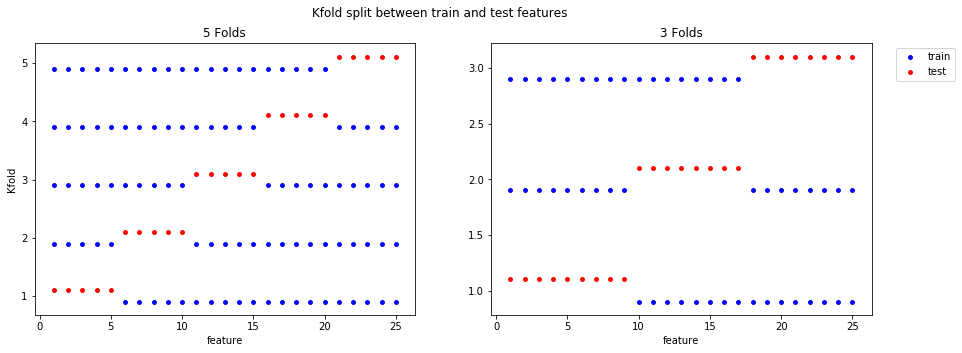

In [11]:
train5, test5 = kfoldize(kf5,rn)
train3, test3 = kfoldize(kf3,rn)

fig,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(x="x",y="val",c="b",label="train",s=15,data=train5)
ax[0].scatter(x="x",y="val",c="r",label="test",s=15,data=test5)
ax[1].scatter(x="x",y="val",c="b",label="train",s=15,data=train3)
ax[1].scatter(x="x",y="val",c="r",label="test",s=15,data=test3)
ax[0].set_ylabel("Kfold")
ax[0].set_xlabel("feature")
ax[1].set_xlabel("feature")
ax[0].set_title("5 Folds")
ax[1].set_title("3 Folds")
plt.suptitle("Kfold split between train and test features")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [12]:
# let's make sure how the values are distributes between the sets; Also we will create function so that we can repeat
def kfold_stats(df, name):
    s =  pd.Series({"Min value: ": df["x"].min(),
              "Max value: ": df["x"].max(),
              "Min occurance: ": df["x"].value_counts().min(),
              "Max occurance: ": df["x"].value_counts().max(),
               "Min lenght": df.groupby("val").count().min().values[0],
               "Max lenght": df.groupby("val").count().max().values[0]})
    s.name = name
    return s
pd.concat([kfold_stats(train5, "Train5"), kfold_stats(test5,"Test5"),
          kfold_stats(train3, "Train3"), kfold_stats(test3,"Test3")], 
          axis=1)

,Train5,Test5,Train3,Test3
Min value:,1,1,1,1
Max value:,25,25,25,25
Min occurance:,4,1,2,1
Max occurance:,4,1,2,1
Min lenght,20,5,16,8
Max lenght,20,5,17,9


The table above summarizes some key facts about the KFold:

* `Min and Max value` - both train and test cover all the features
* `Min and Max occurrence`- each value occurs once in the test set and k-1 times in the train set
* `Min and Max value length` - in case you have a number of features which is not dividable by n, some will have different split between test and train sets. E.g. in case of 25 features and 3 split the ratios as 16/9, 17/8, 17/8

## Shuffled KFold
In the previous example, you have seen the unshuffled train/test distribution. Such distribution can influence the result of the machine learning model so it is often useful to split the features randomly in order to prove the abilities of your model. A random split of the data is achieved by the `shuffle` parameter. `random-state` parameter initiates the randomizer the way that using the same random state ensures the same split. 

In [13]:
kf42 = KFold(n_splits=5, shuffle=True, random_state=42)
kf123 = KFold(n_splits=5, shuffle=True, random_state=123)

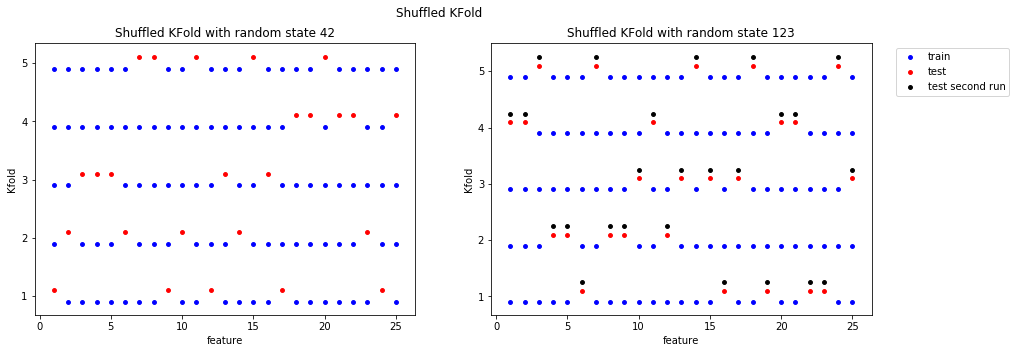

In [14]:
train42, test42 = kfoldize(kf42,rn)
train123, test123 = kfoldize(kf123,rn)
train123_2, test123_2 = kfoldize(kf123,rn,shift=.25)

fig,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(x="x",y="val",c="b",label="train",s=15,data=train42) 
ax[0].scatter(x="x",y="val",c="r",label="test",s=15,data=test42)
ax[1].scatter(x="x",y="val",c="b",label="train",s=15,data=train123)
ax[1].scatter(x="x",y="val",c="r",label="test",s=15,data=test123)
ax[1].scatter(x="x",y="val",c="k",label="test second run",s=15,data=test123_2)
ax[0].set_ylabel("Kfold")
ax[0].set_xlabel("feature")
ax[0].set_title("Shuffled KFold with random state 42")
ax[1].set_ylabel("Kfold")
ax[1].set_xlabel("feature")
ax[1].set_title("Shuffled KFold with random state 123")
plt.suptitle("Shuffled KFold")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

## Kfold on the real dataset
Let's use the Kfold to evaluate a classification model on the popular Iris Dataset. It contains 150 mesaurement of petal and sepal sizes of the 3 varietals of Iris flower - setosa, versicolor and virginica. Each contains 50 measurement in the set. 

Iris dataset on scikit-learn: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

In [112]:
iris = load_iris(return_X_y=False)
iris_df = pd.DataFrame(data=iris.data,columns=iris.feature_names)
features = iris['feature_names']
iris_df['target'] = iris.target
iris_df["target_name"] = iris_df['target'].map({i:name for i,name in enumerate(iris.target_names)})
iris_df.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
19,5.1,3.8,1.5,0.3,0,setosa
120,6.9,3.2,5.7,2.3,2,virginica
98,5.1,2.5,3.0,1.1,1,versicolor
6,4.6,3.4,1.4,0.3,0,setosa
95,5.7,3.0,4.2,1.2,1,versicolor


In [16]:
# Let's see how many samples of each iris type we have in our set
pd.DataFrame(iris_df.groupby("target_name").size().reset_index()).rename(columns={0:"samples"})

,target_name,samples
0,setosa,50
1,versicolor,50
2,virginica,50


### Single fold
Let's perform logistics regression using traditional train_test_split which will split the data into train and test set, so that each target value appear in both training and testing set similar number of times. 

In [17]:
# initialize the model
model = LogisticRegression(solver="liblinear", multi_class="auto")

In [29]:
#Logistic regression without Kfold, just split into 80% train and 20% test set
X = iris_df[features]
y = iris_df["target"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [30]:
#Train the model
model.fit(X_train, y_train) #Training the model
pd.DataFrame({"Accurancy on Train":[accuracy_score(y_train, model.predict(X_train))],
    "Accurancy on Test":[accuracy_score(y_test, model.predict(X_test))]})

,Accurancy on Train,Accurancy on Test
0,0.958333,1.0


### KFold
Kfold method returns the order of the samples chosen for train and test sets in each fold. On a pandas dataframe we have use to .iloc function to get the correct rows. Because I haven't split the data into X (features) and y (target) I have to also use .loc, to choose the right columns (.loc[:,features]) or simply pick the columns (['target'])

In [31]:
i = 1
for train_index, test_index in kf3.split(iris_df):
    X_train = iris_df.iloc[train_index].loc[:, features]
    X_test = iris_df.iloc[test_index][features]
    y_train = iris_df.iloc[train_index].loc[:,'target']
    y_test = iris_df.loc[test_index]['target']
        
    #Train the model
    model.fit(X_train, y_train) #Training the model
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, model.predict(X_test))}")
    i += 1

Accuracy for the fold no. 1 on the test set: 0.0
Accuracy for the fold no. 2 on the test set: 0.0
Accuracy for the fold no. 3 on the test set: 0.0


But why the accuracy is each fold **0.0**? The reason is the uniformity of the splits. Since the data are ordered that setosa appears on the first fifty rows of the dataset, followed by versicolor and virginica we have achieved unique distribution of the training set, that it doesn't contain any target expected in the test set. Most machine learning model cannot learn to clasify into a class which it has never seen.  Which is visible on the third split

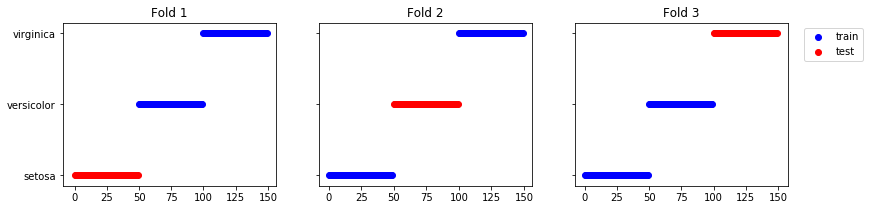

In [32]:
target_name = iris_df["target"]

fig, ax = plt.subplots(1,3, figsize=(13,3), sharey=True)
for i, (train_index, test_index) in enumerate(kf3.split(iris_df)):
    ax[i].scatter(x=train_index,y=target_name.iloc[train_index],label ="train", c='b')
    ax[i].scatter(x=test_index,y=target_name.iloc[test_index], label = "test", c='r')
    ax[i].set_title(f"Fold {i+1}")

ax[0].set_yticks([0,1,2])
ax[0].set_yticklabels(iris["target_names"])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

## Shuffled KFold
One way to get around this issue is to use the shuffled Kfold

In [101]:
kf = KFold(n_splits=3, shuffle=True, random_state=123)
i = 1
for train_index, test_index in kf.split(iris_df):
    X_train = iris_df.iloc[train_index].loc[:, features]
    X_test = iris_df.iloc[test_index].loc[:,features]
    y_train = iris_df.iloc[train_index].loc[:,'target']
    y_test = iris_df.loc[test_index].loc[:,'target']
        
    #Train the model
    model.fit(X_train, y_train) #Training the model
    y_pred = model.predict(X_test)
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, y_pred)}")
    i += 1

Accuracy for the fold no. 1 on the test set: 0.98
Accuracy for the fold no. 2 on the test set: 0.94
Accuracy for the fold no. 3 on the test set: 0.88


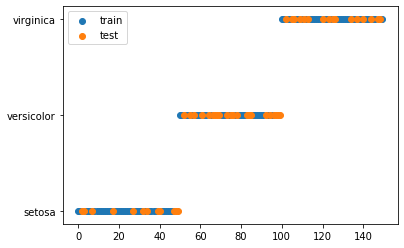

In [102]:
plt.scatter(x=y_train.index,y=iris_df.iloc[train_index].loc[:,'target_name'],label ="train")
plt.scatter(x=y_test.index,y=iris_df.iloc[test_index].loc[:,'target_name'], label = "test")
plt.legend()
plt.show()

You can see that now we pick samples from all three types of irises, however some are chosen more often than others. 

In [103]:
iris_df.iloc[train_index].loc[:,'target_name'].value_counts()

setosa        38
virginica     34
versicolor    28
Name: target_name, dtype: int64

## Stratified KFold

Instead of using random Kfold, we can use StratifiedKFold which needs extra parameter `y`. As `y` you use the target variable so that the Kfold and pick balanced distribution of the targets in each folds.

In [104]:
a = []
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
i = 1
for train_index, test_index in kf.split(iris_df, iris_df["target"]):
    X_train = iris_df.iloc[train_index].loc[:, features]
    X_test = iris_df.iloc[test_index].loc[:,features]
    y_train = iris_df.iloc[train_index].loc[:,'target']
    y_test = iris_df.loc[test_index].loc[:,'target']
        
    #Train the model
    model.fit(X_train, y_train) #Training the model
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, model.predict(X_test))}, doublecheck: {model.score(X_test,y_test)}")
    i += 1

Accuracy for the fold no. 1 on the test set: 1.0, doublecheck: 1.0
Accuracy for the fold no. 2 on the test set: 0.9215686274509803, doublecheck: 0.9215686274509803
Accuracy for the fold no. 3 on the test set: 0.9583333333333334, doublecheck: 0.9583333333333334


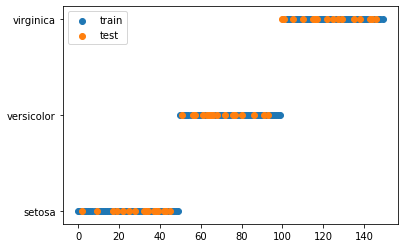

In [105]:
plt.scatter(x=y_train.index,y=iris_df.iloc[train_index].loc[:,'target_name'],label ="train")
plt.scatter(x=y_test.index,y=iris_df.iloc[test_index].loc[:,'target_name'], label = "test")
plt.legend()
plt.show()

In [106]:
iris_df.iloc[train_index].loc[:,'target_name'].value_counts()

versicolor    34
setosa        34
virginica     34
Name: target_name, dtype: int64

## Other metrics

In [110]:
# cross_validate allow to specify metrics which you want to see
for i, score in enumerate(cross_validate(model, X,y, cv=3)["test_score"]):
    print(f"Accuracy for the fold no. {i} on the test set: {score}")

Accuracy for the fold no. 0 on the test set: 0.9607843137254902
Accuracy for the fold no. 1 on the test set: 0.9215686274509803
Accuracy for the fold no. 2 on the test set: 0.9583333333333334


In [109]:
for i, score in enumerate(cross_val_score(model, X,y, cv=3)):
    print(f"Accuracy for the fold no. {i} on the test set: {score}")

Accuracy for the fold no. 0 on the test set: 0.9607843137254902
Accuracy for the fold no. 1 on the test set: 0.9215686274509803
Accuracy for the fold no. 2 on the test set: 0.9583333333333334


# Conclusion
In this example we have reviewed how the Sklearn Kfold method works. We see that it splits the data into the `n` number of sets. Each of the features will appear once in the test set and `n-1` times in the training set.

Each fold will contain `1/n` values in the training set and `n-1/n` values in the testing set. So for `n=2` 50% will be in the test set, `n=3` 33%, `n=4` 25% etc. 

We can either split the data uniformly using `shuffle=False` or randomly with `shuffle=True` and optionally stating a `random_state`. Having the same random state will always result in the same split of test and train data.

it can complement Datacamp course e.g. https://campus.datacamp.com/courses/winning-a-kaggle-competition-in-python/dive-into-the-competition?ex=8